# Machine Learning in Python
## Introductory Notes
Andrew Ng produced an excellent series of video notes on machine learning from the ground up, these can be found here: https://tinyurl.com/y6lptzcy

The **answers** to all of these problems can be found here: https://towardsdatascience.com/andrew-ngs-machine-learning-course-in-python-linear-regression-dd04fba8e137

He uses Octave in his videos, but this notebook will perform the equivalent actions in Python using numpy and matplotlib primarily. There are a few forums and existing Python notebooks which will help translate his Octave work into Python, these are listed below:
* https://github.com/dibgerge/ml-coursera-python-assignments/blob/master/Exercise1/exercise1.ipynb
* https://www.johnwittenauer.net/machine-learning-exercises-in-python-part-1/
* https://www.quora.com/Can-I-take-Andrew-Ngs-machine-learning-class-with-Python-instead-of-Octave
* https://github.com/jdwittenauer/ipython-notebooks/tree/master/notebooks

The below links offer some good cheatsheets for the various formatting I've used throughout this notebook:
* https://sqlbak.com/blog/jupyter-notebook-markdown-cheatsheet
* https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed
* http://tug.ctan.org/info/symbols/comprehensive/symbols-a4.pdf

## Notes on Python (Debugging Help)
A few useful points to bear in mind when debugging issues:
* Python array indices begin from 0, not 1 (which is where Octave indices begin from).
* Python arrays and numpy arrays are different, numpy arrays should be used in all cases here because they allow vector/matrix operations which would not be possible with python arrays (you'd need to use for loops for those which are time consuming and inefficient).
* Runtime errors are often caused by matrix operations attempting addition/multiplication etc. on matrices of diferent dimensions, you can use `shape` to help you debug this.
* Use the `dot` function in numpy for matrix multiplication (e.g. np.dot(A, B)). You can also use A@B in python versions >= 3.5. This is needed because numpy uses element-wise operations for normal math operators (e.g. non-dot notation) which is longer and less efficient.

## 1. Basic Python and Numpy Function
**Task:**
* Return a 5x5 identity matrix by filling in the code `A = np.eye(5)`.

In [1]:
# load libs
import numpy as np # maths and stats
import pandas as pd # dataframes
import matplotlib.pyplot as plt # core plotting
import os # handle file paths
from mpl_toolkits.mplot3d import Axes3D # plot 3d surfaces

# show plots in notebook
%matplotlib inline

# define function
def warmUpExercise():
    # build 5x5 identity matrix
    A = np.identity(5, dtype=float)
    
    # return matrix
    return(A)
    
# show identity matrix
warmUpExercise()

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

## 2. Linear Regression with 1 Variable
A useful resource for refreshing on linear regressions: https://medium.com/@purnasaigudikandula/linear-regression-in-python-with-cost-function-and-gradient-descent-bde9a8d2626

**Task:**
* Implement a linear regression to predict profits for a food truck.
* The data is city population (column 1) and truck profit (column 2).
* We want to build a model of the profit per city and use it to predict new cities that will be profitable.

In [2]:
# read in CSV data
data = np.loadtxt(os.path.join('Course Notes (for reference)',
                               'ml-coursera-python-assignments-master',
                               'Exercise1/Data/ex1data1.txt'),
                  delimiter = ',')

# split features/independent (population) and labels/dependent (profit)
X, y = data[:, 0], data[:, 1] # use upper case X for features

# extract # of training samples
m = y.size

* This is a 2 dimensional dataset which makes a scatter plot a good method of taking an initial look at the data.
* I will use matplotlib.pyplot to visualise data in this notebook, it is a good interface to matplotlib which mimics MATLAB's plotting interface. Other visualisation libraries are listed in this link and offer good alternatives: https://mode.com/blog/python-data-visualization-libraries/
* Note that below I have used `plt.figure()` to create a figure object, this isn't necessary for plotting but does allow me to explicity tweak the figure's parameters which I could not do if I skipped this step.
* This is a simple reference for scatter plots in pyplot: https://matplotlib.org/3.1.0/tutorials/introductory/pyplot.html

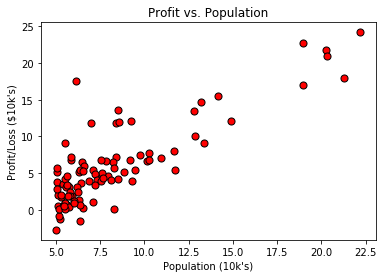

In [3]:
# define scatter plot of data
def scatter(x, y):
    plt.scatter(x, y, marker='o', color='red', edgecolors='black', s=50)
    plt.ylabel('Profit/Loss ($10k\'s)')
    plt.xlabel('Population (10k\'s)')
    plt.title('Profit vs. Population')
    #plt.axis([4.5, 25, -5, 25]) # define xmin/xmax/ymin/ymax
    plt.show()
    
# call function/plot data
scatter(X, y)

In [59]:
# calling this code is equivalent to using shift + (double) tab
# it exposes all the options and parameters
#?pyplot.plot
?pyplot.scatter

## Gradient Descent
Here we will apply a gradient descent method to a linear regression in order to achieve the line of best fit (optimal regression solution).

### a) Update Equations
We are trying to minimize the cost function by altering our $\theta$ values (which are our regression model parameters). The cost function is as follows, where we are minimising ($\frac{1}{2m}$) the cost between our regression features and values (x and y i.e. $\left( h_{\theta}(x^{(i)}) - y^{(i)}\right)^2$) for all values of m (total number of rows in sample) and i (current row index in sample data):

$$ J(\theta) = \frac{1}{2m} \sum_{i=1}^m \left( h_{\theta}(x^{(i)}) - y^{(i)}\right)^2$$

In this formula, the hypothesis $h_\theta(x)$ is shown in the formula below, with just two parameters for a linear regression, but many more for polynomial (to come):

$$ h_\theta(x) = \theta^Tx = \theta_0 + \theta_1 x_1$$

We will be applying a batch gradient descent, which means we will use multiple simultaneous iterations of the process to reach our global (or local) minimum point on the cost function (i.e. make our regression as accurate as possible). The formula for this is as follows, where we aim to minimize $\theta_j$ (i.e. cost function value) by incrementing/decrementing it with our learning rate $\alpha$ (determines size of each step in descent) and the derivative/gradient of our cost function for the current values of $\theta$:

$$ \theta_j = \theta_j - \alpha \frac{1}{m} \sum_{i=1}^m \left( h_\theta(x^{(i)}) - y^{(i)}\right)x_j^{(i)} \qquad \text{simultaneously update } \theta_j \text{ for all } j$$

**NOTE:** $j$ refers to each feature in the dataset (this would just be 1 for a bivariate regression, but would be n for n features).

<div class="alert alert-block alert-warning">
** Implementation Note: ** We add a new first column to $X$ and set it all to ones, this allows us to treat $\theta_0$ as another 'feature' rather than having issues computing it. `numpy` rows are used to build and store our $X$ matrix (i.e. features matrix).
</div>

### b) Computing the Cost $J(\theta)$
We will compute the cost of $J(\theta)$ for different values of $\theta$ in order to minimize our cost function, in this section $X$ refers to our features matrix where columns represent different features and rows are distinct samples, $y$ is a vector whose values correspond to the labels of each row in our $X$ features matrix.

Here, both $X$ and $y$ are 1-dimensional (i.e. vectors) therefore should be fairly straightforward to compute (although, we have added an extra column of ones to $X$, so technically it's 2 dimensional).

**Key:** $\theta$ are the weighting values of your function. You have one value of $\theta$ for each of your feature variables. Initially, you often randomize the values and then use your training data/gradient descent etc. to find the most accurate values of $\theta$ which it then uses to make predictions going forwards. To re-iterate, you weight each one of your features arbitrarily to begin with, check how accurate these are and then enhance (e.g. iteratively with gradient descent) until having achieved the lowest $J(\theta)$/cost function value which is equivalent to the best/most accurate linear regression.

The dot product (see below) of your $\theta$ values and your $X$ features matrix gives you your initial predictions (i.e. you're applying weighting to your features/independent variables to come up with some values of $y$ (labels) to create a linear regression (line). You then calculate the error of this by subtracting your $y$ values (labels/known results) from your predictions (dot product of $X$ and $\theta$) and square it before plugging into the rest of your equation (i.e. the $J(\theta)$ cost function above) to get a cost function score. It's this score which we are aiming to minimize using gradient descent etc. to create the most accurate linear regression model.

In [4]:
# add column of ones to X
# stack joins an array (or sequence of arrays along a new axis)
# numpy joins along a given axis (0=rows/training examples, 1=columns/features)
X = np.stack([np.ones(m), X], axis=1)

# function to calculate cost function value
def computeCost(X, y, theta):
    # initialise variables
    m = y.size # sample size
    J = 0 # cost function value
    
    # dot product (matrix multiplication) of X features matrix and theta
    # theta has one value per feature (for 2 features, theta is a 2d array...)
    # these are predictions b/c you're plugging in your current guess of theta
    # (i.e. feature) values and seeing what your output predicted y values are
    # this is your h(x) which is your regression line
    predictions = X.dot(theta)
    
    # find the error between predictions and known labels and square
    square_err = (predictions - y)**2
    
    # plug into cost function to get final score
    J = 1/(2*m) * np.sum(square_err)
    
    # return cost function value
    return J

The above code is equivalent to the $J(\theta)$ function (see above paragraphs), we can plug in dummy $\theta$ values to calculate cost function scores.

Note that $\theta$ must be an array where each value corresponds to each feature in our data ($X$ matrix) because we need one weighting value per feature (i.e. if there are 4 features in our sample data, we need $\theta$ to be a 1x4 array).

Also, in the first example below, we use $\theta$ of [0, 0] and this means that when we make our predictions (i.e. calculate the dot product of $\theta$ weighting values and $X$ feature values that all results will be 0 (because you're multiplying by 0). Hence, the square error will simply be the square of the sum of all $y$ values (i.e. known labels).

In [6]:
# test with theta values of [0, 0] (i.e. X matrix will be all 0s)
J = computeCost(X, y, theta=np.array([0.0, 0.0]))
print('With theta = [0, 0] \nCost computed = %.2f' % J)
print('Expected cost value (approximately) 32.07\n')

# test with another set of theta values
J = computeCost(X, y, theta=np.array([-1, 2]))
print('With theta = [-1, 2]\nCost computed = %.2f' % J)
print('Expected cost value (approximately) 54.24')

With theta = [0, 0] 
Cost computed = 32.07
Expected cost value (approximately) 32.07

With theta = [-1, 2]
Cost computed = 54.24
Expected cost value (approximately) 54.24


### c) Gradient Descent
Here we will implement the gradient descent algorithm to determine the optimum values of $\theta$ for each of our feature variables.

Gradient descent is an iterative/step-wise process, therefore we will conduct it within a loop, implementing our `computeCost` function from above each time. A good way to track if gradient descent is working is to plot the cost function $J(\theta)$ against the number of iterations and ensure that it is decreasing each iteration and stabilises/converges by the end of our process. If it increases at any point or does not converge then we need to tweak something (e.g. $\alpha$).

Note that in this process, the only things we are changing are the $\theta$ values and never X or y.

Note also that in the below, **dot products in numpy aren't matrix multiplications**, therefore an `m x n` matrix dot product with a `1 x n` matrix won't result in an `m x n` matrix, it instead sums the products within each row and gives a reduced dimension result. See documentation at the below two links:
* https://stackoverflow.com/questions/21562986/numpy-matrix-vector-multiplication
* https://numpy.org/doc/stable/reference/generated/numpy.dot.html

<div class="alert alert-box alert-warning">
**Vectors and matrices in `numpy`** - Important implementation notes
- `numpy` vectors are 1D arrays (e.g. `np.array([1, 2, 3])') whilst a matrix is a 2D (or more) array (e.g. `np.array([[1, 2, 3], [4, 5, 6]])`). However, we also class `np.array([[1, 2, 3]])` as a matrix since it has 2 dimensions (due to brackets) even if it looks like a vector because it is 1x3.
<div>
<a id="gradientDescent"></a>

In [5]:
# gradient descent function
def gradientDescent(X, y, theta, alpha, num_iters):
    # initialize useful values
    m = y.shape[0] # get sample size
    theta = theta.copy() # maintain original theta, avoid changing actual input
    J_history = [] # track each J score for plotting
    
    # iterate through limit
    for i in range(num_iters):
        # apply feature weightings (theta matrix) to features (X matrix)
        # to predict outcomes (y vector)
        predictions = X.dot(theta)
        
        # error is predictions - y (as before) multiplied by X transposed
        error = np.dot(X.transpose(), (predictions - y))
        
        # calculate gradient descent increment/descent
        descent = alpha * (1/m) * error
        
        # adjust theta
        theta -= descent
        
        # track cost function of current theta
        J_history.append(computeCost(X, y, theta))
        
    # return final theta and cost function scores
    return(theta, J_history)

We can now check what our optimized $\theta$ values are and plot our optimized regression line against our training data.

Theta found by gradient descent: -3.6303, 1.166362
Expected theta values (approximately): [-3.6303, 1.1664]
Optimized Hypothesis: h(x) = -3.63 + 1.17x


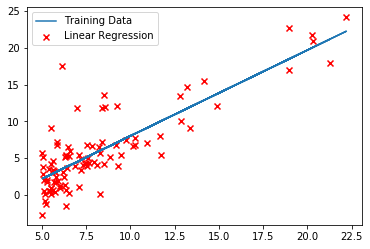

In [7]:
# initialize fitting parameters
theta = np.zeros(2) # 1x2 vector, 2 values (one for each feature in X)

# gradient descent parameters
iterations = 1500
alpha = 0.01

theta, J_history = gradientDescent(X, y, theta, alpha, iterations)
print('Theta found by gradient descent: {:.4f}, {:4f}'.format(*theta))
print('Expected theta values (approximately): [-3.6303, 1.1664]')

# plot data and regression line
plt.scatter(X[:, 1], y, c='r', marker='x') # scatter train features and labels
plt.plot(X[:, 1], np.dot(X, theta), '-') # plot features predictions using optimised theta
plt.legend(['Linear Regression', 'Training Data']) # add legend

# print final (optimized) hypothesis
print("Optimized Hypothesis: h(x) = " + str(round(theta[0],2)) + " + " + str(round(theta[1],2)) + "x")

I've added code above to print out the final (~ solved) hypothesis: $h\theta(x) = -3.63 + 1.17x_{1}$

For personal satisfaction and thoroughness, I am going to plot my $J(\theta)$ cost function values against the number of iterations to ensure the value doesn't increase at any point and that it converges.

It appears to converge fairly effectively and never looks to increase, therefore this appears to be a good gradient descent with appropriate parameters (i.e. $\alpha$, # of iterations...).

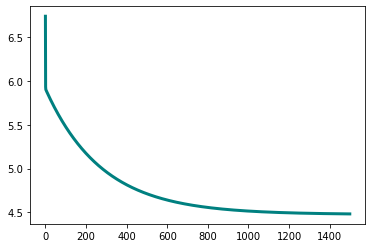

In [8]:
# plot cost function value against # iterations
plt.plot(range(1500), J_history,
         color='teal', linewidth=3)

We can now use our optimized regression to predict profit given population size.

In [9]:
# pass example data (1s in first col and 3.5 to represent scaled 35k)
predict1 = np.dot([1, 3.5], theta)
predict2 = np.dot([1, 7], theta)

# print predictions
print('For a population of 35,000, we predict a profit of {:.2f}\n'.format(predict1*10000))
print('For a population of 70,000, we predict a profit of {:.2f}\n'.format(predict2*10000))

For a population of 35,000, we predict a profit of 4519.77

For a population of 70,000, we predict a profit of 45342.45



The above code is the in-depth, under the hood code to really play around with the underlying formulas and algebra that constitues a linear regression algorithm. However, there are libraries in python which make this a lot easier for you and don't require you to play around with the formulas, parameters etc.

One of the best ML libraries in python is `sklearn` (a.k.a. scikit-learn) which contains modules for almost every ML algorithm and process you could imagine. Below, we run the same process as we did above (i.e. building a linear regression) except in far fewer steps.

As a general rule, I would like to use the above case in a real world pipeline because I have complete control over every aspect, but if you want to save time, have a first 'light-touch' run-through or if you don't understand the ins and outs of the above technical aspects, this is a good process to use below.

The framework code for the below regression can be found here: https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html

A couple of implementation notes for the below code:
* I used `.reshape(-1, 1)` to convert my python column of data into a numpy array. The actual numbers/data don't change at all, this simply fits the data into the exact, correct numpy object that is compatible with my $y$ variables and that numpy likes to work with.
* The coefficient for a 2 variable linear regression (i.e. this example) tells you how much the mean of the dependent variable ($y$ value - profit) changes given a 1 unit shift in the independent variable ($x$ value - population) whilst other variables (none in this case) are kept the same. Below, this is 1.19, which means if the population changes by 1, the mean of the profit will change by 1.19 (showing a positive correlation on average).
* $Mean squared error (MSE)$ is part of the formulas from above (the $x - y squared$ part), the higher this is, the greater the average error between your predicted values and your actual $y$ values, therefore you want this to be low for a good regression fit. 0 would be a perfect score but is unlikely and would mean over-fitting, the main purpose of the MSE is for picking one prediction moedl over another (i.e. forget the actual value, is it higher or lower than other models).
* The $r2 (r-squared)$ value is another indicator of regression fit, it ranges between 0 and 100% (or 0 to 1) with 100% being a perfect fit (likely over-fitted) and 0% meaning no correlation (i.e. a shocking regression). It's defined as 'the proportion of variance in the dependent variable ($y$) that is predictable from the independent variable(s) $(x)$. This is also know as the coefficient of determination (below).
* Further definitions here: https://www.bmc.com/blogs/mean-squared-error-r2-and-variance-in-regression-analysis/

Coefficients: 
 [1.19303364]
Mean Squared Error: 8.95
Coef. of Determination: 0.70


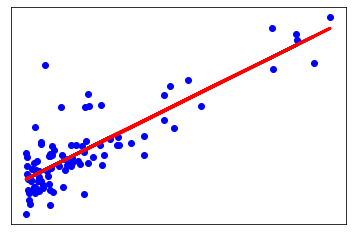

In [10]:
# load libs
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# extract X
X_new = X[:,1].reshape(-1,1)

# create linear regression object
regr = linear_model.LinearRegression()

# train model
regr.fit(X_new, y)

# make predictions
predictions = regr.predict(X_new)

# show coefficients, MSE and coef. of determination
print('Coefficients: \n', regr.coef_)
print('Mean Squared Error: %.2f' % mean_squared_error(y, predictions))
print('Coef. of Determination: %.2f' % r2_score(y, predictions))

# plot results
plt.scatter(X_new, y, color='blue')
plt.plot(X_new, predictions, color='red', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

### d) Visualising $J(\theta)$
To visualise and fully understand the gradient descent method, we will now plot the values of $\theta_{0}$ and $\theta_{1}$ as both a 3D surface plot and a countour plot (using matplotlib's `plot_surface` and `contourf` plots respectively).

This allows us to visualise the cost function $J(\theta)$ and identify where the global minimum is (for this data, there is a single global minimum which helps simplify things as the gradient descent algorithm won't get trapped in local minima depending on the starting values of $\theta$). The aim of gradient descent is to reach this global minimum point of $J(\theta)$ in incremental steps (as shown above) by progressing down the gradients of the contour in the quickest/steepest steps possible.

Useful link for 3D plotting: https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html

Text(0.5, 1.0, 'Contour, showing minimum')

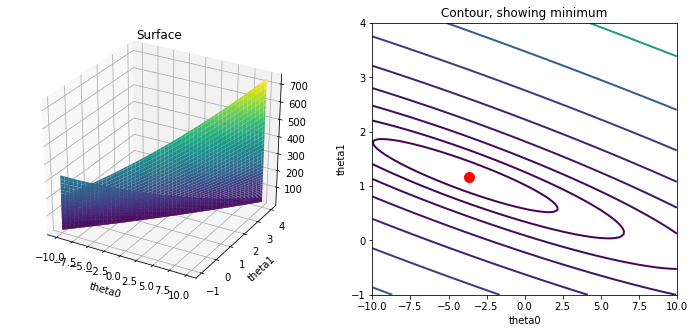

In [11]:
# grid for calculating J (limit it for simplicity of viewing)
theta0_vals = np.linspace(-10, 10, 100)
theta1_vals = np.linspace(-1, 4, 100)

# initialize J_vals with matrix of 0's (100x100 matrix of 0's)
J_vals = np.zeros((theta0_vals.shape[0], theta1_vals.shape[0]))

# populate J_vals
for i, theta0 in enumerate(theta0_vals):
    for j, theta1 in enumerate(theta1_vals):
        J_vals[i, j] = computeCost(X, y, [theta0, theta1])

# b/c of how meshgrids work during below surf command,
# we must transpose to avoid axes being flipped
J_vals = J_vals.T

# surface plot
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(theta0_vals, theta1_vals, J_vals, cmap='viridis')
plt.xlabel('theta0')
plt.ylabel('theta1')
plt.title('Surface')

# contour plot
ax = plt.subplot(122)
plt.contour(theta0_vals, theta1_vals, J_vals, linewidths=2,
            cmap='viridis', levels=np.logspace(-2, 3, 20))
plt.xlabel('theta0')
plt.ylabel('theta1')
plt.plot(theta[0], theta[1], 'ro', ms=10, lw=2)
plt.title('Contour, showing minimum')

## 3) Linear Regression with Multiple Variables
The next dataset contains more than one feature/predictor/independent variables which means we need to adjust our process slightly to handle this. This dataset contains house prices in Portland, Oregon as well as 2 other variables (number of bedrooms and size in square feet).

### a) Feature Normalisation
When dealing with multiple feature variables that differ by any magnitude, it is required to normalise the variables to have the same (or a very similar) scale. This not only makes visual comparison far easier but is required for gradient descent to ensure it doesn't take a long time. If you don't normalise your scales, the above contour map would appear very elongated and the gradient descent algorithm would end up bouncing back and forth because all gradients around it are incredibly steep.

In [16]:
# read in CSV data
data = np.loadtxt(os.path.join('Course Notes (for reference)',
                               'ml-coursera-python-assignments-master',
                               'Exercise1/Data/ex1data2.txt'),
                  delimiter = ',')

# load as df also
data_df = pd.read_csv(os.path.join('Course Notes (for reference)',
                                   'ml-coursera-python-assignments-master',
                                   'Exercise1/Data/ex1data2.txt'),
                      header=None)

# extract variables
X = data[:,:2] # size in square feet, # of bedrooms
y =  data[:,2] # house prices
m = y.size # number of samples/rows

# investigate data
print(data_df.head(5))
data_df.describe()

      0  1       2
0  2104  3  399900
1  1600  3  329900
2  2400  3  369000
3  1416  2  232000
4  3000  4  539900


0          1              2
count    47.000000  47.000000      47.000000
mean   2000.680851   3.170213  340412.659574
std     794.702354   0.760982  125039.899586
min     852.000000   1.000000  169900.000000
25%    1432.000000   3.000000  249900.000000
50%    1888.000000   3.000000  299900.000000
75%    2269.000000   4.000000  384450.000000
max    4478.000000   5.000000  699900.000000

The above code gives us an indication of the distribution of each variable, we can combine this with an initial scatter plot of each X variable against the y values below to get a better understanding of how the data is distributed.

As you might imagine, price increases with house size and also with number of bedrooms.

The scales of both variables range dramatically though, with house size being ~1000 times bigger than # of bedrooms. Therefore we will move onto feature normalization.

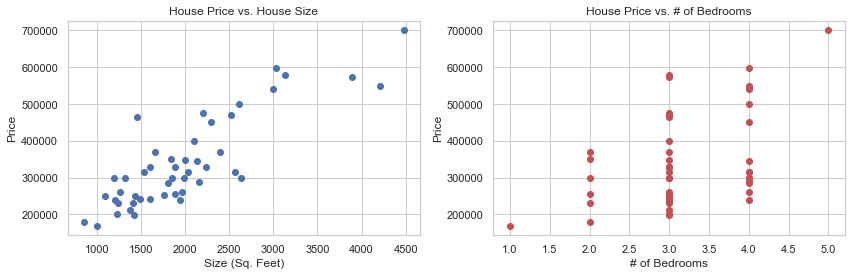

In [44]:
# create 1 subplot per variable
fig, axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)

# plot both variables in separate subplots
axes[0].scatter(X[:,0],y,color='b')
axes[0].set_xlabel('Size (Sq. Feet)')
axes[0].set_ylabel('Price')
axes[0].set_title('House Price vs. House Size')
axes[1].scatter(X[:,1],y,color='r')
axes[1].set_xlabel('# of Bedrooms')
axes[1].set_ylabel('Price')
axes[1].set_title('House Price vs. # of Bedrooms')

# enhance layout
plt.tight_layout()

In this instance I will use mean normalization, where you subtract the variable mean from the values and then divide by standard deviation. There are many methods of feature normalization, each with their own pros and cons, in a real world scenario it's a good idea to use sklearn's gridSearch library to run multiple normalization types and determine which gives the best result, but here we will just use this one method.

The below method will take all feature variables, calculate the mean and std for each feature variable, calculate the normalized values for each variable and return everything. Note that we keep the original input data because whilst the normalized values help us run our ML model, we still need the original scales etc. when outputting actual results at the end.

In [46]:
# method to compute feature normalization for all features
def featureNormalization(X):
    # instantiate vars
    mean = np.mean(X, axis=0) # get mean of each column
    std = np.std(X, axis=0) # get std of each column
    
    # calculate new x values
    X_norm = (X - mean) / std # calculate normalized vals for each column
    
    # return normalized x values
    return X_norm, mean, std # return all 3

Running the same plots as above but now on the normalized data, you can see that the scales of both feature variables have been reduced and centered around 0.

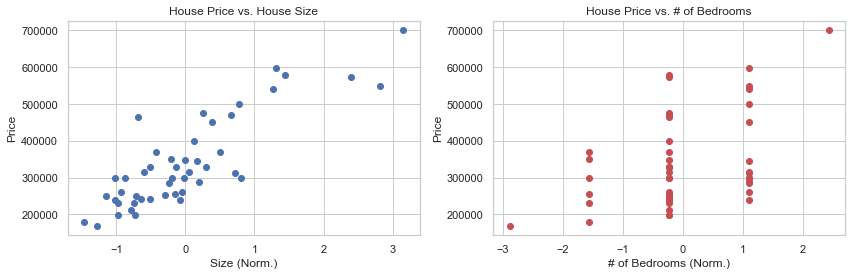

In [53]:
# run feature normalization on features
X2, mean_X2, std_X2 = featureNormalization(X)

# create 1 subplot per variable
fig, axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)

# plot both variables in separate subplots
axes[0].scatter(X2[:,0],y,color='b')
axes[0].set_xlabel('Size (Norm.)')
axes[0].set_ylabel('Price')
axes[0].set_title('House Price vs. House Size')
axes[1].scatter(X2[:,1],y,color='r')
axes[1].set_xlabel('# of Bedrooms (Norm.)')
axes[1].set_ylabel('Price')
axes[1].set_title('House Price vs. # of Bedrooms')

# enhance layout
plt.tight_layout()

In [63]:
# update parameters for normalized data to run gradient descent
m2 = X2.shape[0] # sample size
X2 = np.append(np.ones((m2,1)), X2, axis=1) # add col of 1s
y2 = 
theta2 = np.zeros((3,1)) # 3 theta values this time (2 features + 1 col of 1s)

47

In [65]:
y2 = X2[:,-1]
y2

array([-0.22609337, -0.22609337, -0.22609337, -1.5543919 ,  1.10220517,
        1.10220517, -0.22609337, -0.22609337, -0.22609337, -0.22609337,
        1.10220517, -0.22609337, -0.22609337,  2.4305037 , -0.22609337,
        1.10220517, -1.5543919 , -0.22609337,  1.10220517,  1.10220517,
       -0.22609337, -1.5543919 , -0.22609337,  1.10220517, -0.22609337,
       -0.22609337, -0.22609337, -0.22609337, -0.22609337, -0.22609337,
       -1.5543919 , -2.88269044,  1.10220517, -0.22609337,  1.10220517,
       -0.22609337, -0.22609337,  1.10220517,  1.10220517,  1.10220517,
       -1.5543919 , -0.22609337,  1.10220517, -0.22609337, -1.5543919 ,
        1.10220517, -0.22609337])